# Training

*Creators: Lajos Bodo, Szilard Kosa*

Description: The program opens the dataset, preprocesses it, then trains the network.

In [1]:
# This library let's us work with hdf5 format files.
import tables
# Fundamental package for scientific computing with Python.
import numpy as np
# Used for printing the current progress only
from IPython.display import clear_output

# Setting the random seeds.
np.random.seed(1)
from tensorflow import set_random_seed
set_random_seed(2)
import random as rn
rn.seed(2)

# Opening the dataset.
hdf5_path = "dataset.hdf5"
hdf5_file = tables.open_file(hdf5_path, mode='r')
print("Opening %s ."%(hdf5_path))

# Defining the number of pictures loaded for each person.
picture_per_person = 5

# Lists for storing the data from the dataset.
X = []
Y = []

# Defining variables needed for the algorithm.
data_num = hdf5_file.root.images.shape[0]
prev_label = hdf5_file.root.labels[0]
count = 0

# Reads the defined amount of pictures for each person.
for i in range(data_num):
    label = hdf5_file.root.labels[i]
    if i%1000 == 0:
        clear_output(wait=True)
        print("Loading: %.3f %%"%(float(i)/float(data_num-1)*100))
    if label != prev_label:
        count = 0

    if count < picture_per_person:
        X.append(hdf5_file.root.images[i])
        Y.append(label)
        count += 1
     
    prev_label = label

# Closing the file.
hdf5_file.close()
print()
print("HDF5 file closed.")

Loading: 99.898 %

HDF5 file closed.


## Splitting the dataset

In this cell we split the dataset into the training, the validation and the test parts.

In [2]:
# Defining the variables to split the dataset.
valid_split = 0.1
test_split = 0.1
# Calculating the splitting indexes.
nb_samples = len(Y)
valid_index = int(nb_samples*(1-valid_split-test_split)//picture_per_person)*picture_per_person
test_index = int(nb_samples*(1-test_split)//picture_per_person)*picture_per_person

# Splitting and standardizing the dataset.
X_train = [i/255 for i in X[0:valid_index]]
Y_train = [i/255 for i in Y[0:valid_index]]
X_valid = [i/255 for i in X[valid_index:test_index]]
Y_valid = [i/255 for i in Y[valid_index:test_index]]
X_test  = [i/255 for i in X[test_index:]]
Y_test  = [i/255 for i in Y[test_index:]]
print("Number of elements in X_train: %i" %(len(X_train)))
print("Number of elements in Y_train: %i" %(len(Y_train)))
print("Number of elements in X_valid: %i" %(len(X_valid)))
print("Number of elements in Y_valid: %i" %(len(Y_valid)))
print("Number of elements in X_test: %i" %(len(X_test)))
print("Number of elements in Y_test: %i" %(len(Y_test)))

Number of elements in X_train: 35580
Number of elements in Y_train: 35580
Number of elements in X_valid: 4445
Number of elements in Y_valid: 4445
Number of elements in X_test: 4450
Number of elements in Y_test: 4450


## Preproccessing training data

Here, we split the training data into the training batches.

In [3]:
X_train_batch = []
Y_train_batch = []
# Defining the number of persons included in a batch.
person_per_batch = 10
# Calculating the number of pictures in a batch.
picture_per_batch = picture_per_person*person_per_batch
# Calculating number of batches.
batch_number = int(len(Y_train)//picture_per_batch)
print("The number of batches used in training: {}".format(batch_number))
for i in range(batch_number):
    X_train_batch.append(X_train[i*picture_per_batch:(i+1)*picture_per_batch])
    Y_train_batch.append(Y_train[i*picture_per_batch:(i+1)*picture_per_batch])

The number of batches used in training: 711


## Preproccessing validation data 

Here, we split the validation data into the validation batches.

In [4]:
X_valid_batch = []
Y_valid_batch = []
# Calculating number of batches.
batch_number = int(len(Y_valid)//picture_per_batch)
print("The number of batches used in validation: {}".format(batch_number))
for i in range(batch_number):
    X_valid_batch.append(X_valid[i*picture_per_batch:(i+1)*picture_per_batch])
    Y_valid_batch.append(Y_valid[i*picture_per_batch:(i+1)*picture_per_batch])

The number of batches used in validation: 88


## Preproccessing test data 

Creating lists for the test data. The positives will contain pairs from the same person. The negatives will contain pairs from two different persons.

In [5]:
X_test_positives = []
Y_test_positives = []
X_test_negatives = []
Y_test_negatives = []

# The test data is cut in half annd loaded into the lists defined above.
half_index_test = int((0.5*len(X_test)//picture_per_person)*picture_per_person)
X_test_positives = X_test[0:half_index_test]
Y_test_positives = Y_test[0:half_index_test]
print("Number of elements in X_test_positives: %i" %(len(X_test_positives)))
print("Number of elements in Y_test_positives: %i" %(len(Y_test_positives)))

# The negatives list is made with the following technique:
# In the first half of the list, to every second place we insert a random element from the second half.
# This way every two following pictures are from different persons.
half_index_test_negatives = half_index_test + int((0.5*len(Y_test[half_index_test:])//picture_per_person)*picture_per_person)
x_test_negatives = X_test[half_index_test:half_index_test_negatives]
y_test_negatives = Y_test[half_index_test:half_index_test_negatives]
randperm = np.random.permutation(len(Y_test[half_index_test_negatives:]))
for i in range(int(len(x_test_negatives)/picture_per_person)):
    for j in range(picture_per_person):
        X_test_negatives.append(x_test_negatives[i*picture_per_person+j])
        X_test_negatives.append(X_test[randperm[i*picture_per_person+j]+half_index_test_negatives])
        Y_test_negatives.append(y_test_negatives[i*picture_per_person+j])
        Y_test_negatives.append(Y_test[randperm[i*picture_per_person+j]+half_index_test_negatives])
print("Number of elements in X_test_negatives: %i" %(len(X_test_negatives)))
print("Number of elements in Y_test_negatives: %i" %(len(Y_test_negatives)))

Number of elements in X_test_positives: 2225
Number of elements in Y_test_positives: 2225
Number of elements in X_test_negatives: 2220
Number of elements in Y_test_negatives: 2220


## Training

Importing the necessary parts from keras.

In [6]:
import keras
from keras.layers import Conv2D, MaxPooling2D, Input, Dense, Flatten, Lambda
from keras.models import Model
import keras.backend as K

Using TensorFlow backend.


Due to the lack of high-level implementation of triplet loss training method we create a simple model to test our solution. Because of the simplicity of this model it's not the most suitable for this task. Future improvements are needed.

In [7]:
# First, define the vision modules
digit_input = Input(shape=(64, 64, 1))
x = Conv2D(64, (3, 3))(digit_input)
x = Conv2D(64, (3, 3))(x)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(64, (3, 3))(x)
x = Conv2D(64, (3, 3))(x)
x = MaxPooling2D((2, 2))(x)
x = Flatten()(x)
out = Dense(128, activation='relu')(x)
norm_layer = Lambda(lambda  x: K.l2_normalize(x,axis=1))(out)

vision_model = Model(digit_input, norm_layer)

With the previously defined model we create a model with three inputs. It was done with Keras functional api.

In [8]:
# Then define the tell-digits-apart model
in_a = Input(shape=(64, 64, 1))
in_p = Input(shape=(64, 64, 1))
in_n = Input(shape=(64, 64, 1))

# The vision model will be shared, weights and all
out_a = vision_model(in_a)
out_p = vision_model(in_p)
out_n = vision_model(in_n)

concatenated = keras.layers.concatenate([out_a, out_p, out_n])

model = Model([in_a, in_p, in_n], concatenated)

In [9]:
vision_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 64, 64, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 62, 62, 64)        640       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 60, 60, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 30, 30, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 28, 28, 64)        36928     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 26, 26, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 13, 13, 64)        0         
__________

In [10]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 64, 64, 1)    0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            (None, 64, 64, 1)    0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            (None, 64, 64, 1)    0                                            
__________________________________________________________________________________________________
model_1 (Model)                 (None, 128)          1496000     input_2[0][0]                    
                                                                 input_3[0][0]                    
          

The following function is a custom loss function based on the one used at https://thelonenutblog.wordpress.com/2018/02/13/how-to-potty-train-a-siamese-network/
It's been modified to match the one mentioned in the FaceNet paper.

In [11]:
def triplet_loss(y_true, y_pred, alpha = 0.4):
    """
    Implementation of the triplet loss function
    Arguments:
    y_true -- true labels, required when you define a loss in Keras, you don't need it in this function.
    y_pred -- python list containing three objects:
            anchor -- the encodings for the anchor data
            positive -- the encodings for the positive data (similar to anchor)
            negative -- the encodings for the negative data (different from anchor)
    Returns:
    loss -- real number, value of the loss
    """

    anchor = y_pred[:,:128]
    positive = y_pred[:,128:256]
    negative = y_pred[:,256:]

    # distance between the anchor and the positive
    pos_dist = K.sum(K.square(anchor-positive),axis=1)

    # distance between the anchor and the negative
    neg_dist = K.sum(K.square(anchor-negative),axis=1)

    # compute loss
    basic_loss = pos_dist-neg_dist+alpha
    loss = K.maximum(basic_loss,0.0)
 
    return loss

Compiling the model with Adam optimiser and with triplet_loss function defined above.

In [12]:
from keras import optimizers

adam = optimizers.Adam(0.0001)

model.compile(optimizer=adam,
                  loss=triplet_loss)

The triplets are generated during training with the following generator. It generates only hard, and semi-hard triplets from the training batches. It can be also used to generate triplets for validation, when the for_training parameter is set to False.

In [13]:
# for generating the combinations
import itertools

# defining a triplet loss function, that uses numpy for calculations
def tripletloss(anchor, positive, negative, alpha = 0.4):
    # distance between the anchor and the positive
    pos_dist = np.sum(np.square(anchor-positive))

    # distance between the anchor and the negative
    neg_dist = np.sum(np.square(anchor-negative))

    # compute loss
    basic_loss = pos_dist-neg_dist+alpha
    loss = np.maximum(basic_loss,0.0)
 
    return loss

def triplet_generator(network, X, for_training = True):
    while True:
        # interating through the batches
        for index in range(len(X)):
            # creating lists to store the images and the predictions
            preds = []
            imgs = []
            # storing picture_per_batch amount of pictures
            for i in range(picture_per_batch):
                # dimension expansion
                img = np.expand_dims(X[index][i], axis=0)
                img = np.expand_dims(img, axis=3)
                imgs.append(img)
                preds.append(network.predict([img,img,img])[0][0:128])
            # creating all of the possible picture combinations per person
            duos = []
            img_duos = []
            for i in range(person_per_batch):
                for duo in itertools.combinations(imgs[i*picture_per_person:(i+1)*picture_per_person],2):
                    img_duos.append(duo)
                for duo in itertools.combinations(preds[i*picture_per_person:(i+1)*picture_per_person],2):
                    duos.append(duo)
            # creating the triplets
            triplets = []
            img_triplets = []
            # interating through every person
            for i in range(person_per_batch):
                # the number of picture combinations per person
                dn = int(len(duos)/person_per_batch)
                # iterating through all the combinations, and finding the right triplets
                for j in range(dn):
                    ind = dn*i+j
                    iter = 0
                    found = False
                    # Iterating through the whole batch to find a hard or a semi-hard negative.
                    # If none of them is suitable, then that combination is discarded.
                    while iter<picture_per_batch and not found:
                        if for_training:
                            if iter not in range(i*picture_per_person,(i+1)*picture_per_person) and tripletloss(duos[ind][0],duos[ind][1],preds[iter]) > 0:
                                triplets.append([duos[ind][0],duos[ind][1],preds[iter]])
                                img_triplets.append([img_duos[ind][0],img_duos[ind][1],imgs[iter]])
                                found = True
                        # if it is for validation then it is not necessary to find a hard or semi-hard negítive
                        else:
                            if iter not in range(i*picture_per_person,(i+1)*picture_per_person):
                                triplets.append([duos[ind][0],duos[ind][1],preds[iter]])
                                img_triplets.append([img_duos[ind][0],img_duos[ind][1],imgs[iter]])
                                found = True
                        iter += 1
            # transforming the results into the shape the model expects
            batch_size = len(img_triplets)
            batch1 = np.zeros((batch_size,64,64,1))
            batch2 = np.zeros((batch_size,64,64,1))
            batch3 = np.zeros((batch_size,64,64,1))
            for b in range(batch_size):
                batch1[b] = img_triplets[b][0][0,...]
                batch2[b] = img_triplets[b][1][0,...]
                batch3[b] = img_triplets[b][2][0,...]
            batch_x = [batch1,batch2,batch3]
            batch_y = np.zeros(batch_size)
            yield( batch_x, batch_y )

Displaying triplets from the first batch generated by the triplet_generator.

SHAPE OF THE BATCH: (100, 64, 64, 1)
1th Triplets of 100:
Positive distance: 0.23816022276878357
Negative distance: 0.10584641247987747
Prediction: 0.53:


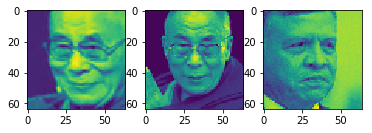

2th Triplets of 100:
Positive distance: 0.18912139534950256
Negative distance: 0.10584641247987747
Prediction: 0.48:


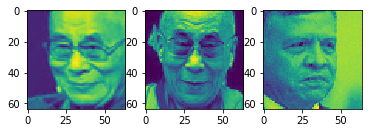

3th Triplets of 100:
Positive distance: 0.2072850465774536
Negative distance: 0.10584641247987747
Prediction: 0.50:


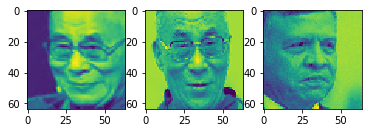

4th Triplets of 100:
Positive distance: 0.1815047562122345
Negative distance: 0.10584641247987747
Prediction: 0.48:


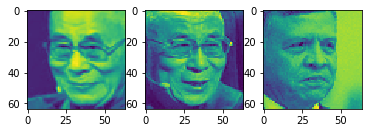

5th Triplets of 100:
Positive distance: 0.27692270278930664
Negative distance: 0.337810754776001
Prediction: 0.34:


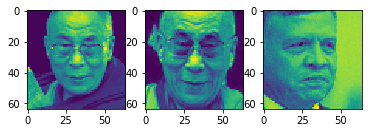

6th Triplets of 100:
Positive distance: 0.39434266090393066
Negative distance: 0.337810754776001
Prediction: 0.46:


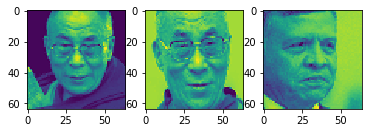

7th Triplets of 100:
Positive distance: 0.22056816518306732
Negative distance: 0.337810754776001
Prediction: 0.28:


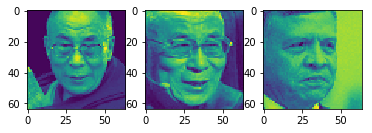

8th Triplets of 100:
Positive distance: 0.2840636968612671
Negative distance: 0.24755558371543884
Prediction: 0.44:


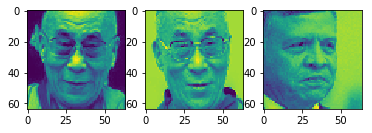

9th Triplets of 100:
Positive distance: 0.19572919607162476
Negative distance: 0.24755558371543884
Prediction: 0.35:


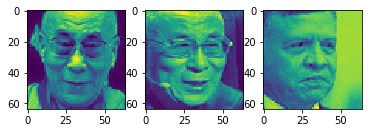

10th Triplets of 100:
Positive distance: 0.2523620128631592
Negative distance: 0.1341795176267624
Prediction: 0.52:


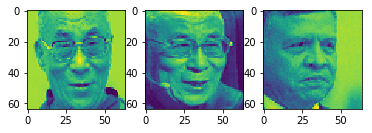

In [14]:
# we use matplotlib to display the images
import matplotlib.pyplot as plt
%matplotlib inline

# creating an instance of the generator
generator = triplet_generator(model,X_train_batch)
i = 0
for batch in generator:
    print("SHAPE OF THE BATCH: {}".format(batch[0][2].shape))
    for tri in range(10):
        anch = np.expand_dims(batch[0][0][tri,...], axis=0)
        pos = np.expand_dims(batch[0][1][tri,...], axis=0)
        neg = np.expand_dims(batch[0][2][tri,...], axis=0)
        print("{}th Triplets of {}:".format(tri+1,len(batch[1])))
        # creating predictions
        preds = model.predict([anch,pos,neg])[0]
        anch_pred = preds[:128]
        pos_pred = preds[128:256]
        neg_pred = preds[256:]
        print("Positive distance: {}".format(np.sum(np.square(anch_pred-pos_pred))))
        print("Negative distance: {}".format(np.sum(np.square(anch_pred-neg_pred))))
        loss = tripletloss(anch_pred,pos_pred,neg_pred)
        print("Prediction: %.2f:"%(loss))
        f, axarr = plt.subplots(1,3)
        axarr[0].imshow(anch[0][:,:,0])
        axarr[1].imshow(pos[0][:,:,0])
        axarr[2].imshow(neg[0][:,:,0])
        plt.show()
    i = i+1
    if i > 0:
        break

Training the model with the generators.

In [15]:
train_generator = triplet_generator(model, X_train_batch)
valid_generator = triplet_generator(model, X_valid_batch, for_training = False)
history = model.fit_generator(
      train_generator,
      steps_per_epoch=len(X_train_batch),
      epochs=1,
      validation_data=valid_generator,
      validation_steps = len(X_valid_batch),
      verbose=1)

Epoch 1/1
382/711 [===============>..............] - ETA: 2:32 - loss: 0.3092

KeyboardInterrupt: 

In [ ]:
# Retrieve a list of list results on training and test data
# sets for each training epoch
loss = history.history['loss']
val_loss = history.history['val_loss']

# Get number of epochs
epochs = range(len(loss))

plt.figure()

# Plot training and validation loss per epoch
plt.plot(epochs, loss)
plt.plot(epochs, val_loss)
plt.title('Training and validation loss')

Displaying triplets of the first batch generated by the triplet_generator. This time it is visible, that the triplets are more similar looking, meaning the network works as we expected. It generates harder and harder triplets as it learns to recognize the features.

In [ ]:
generator = triplet_generator(model,X_train_batch)
i = 0
for batch in generator:
    print("SHAPE OF THE BATCH: {}".format(batch[0][2].shape))
    for tri in range(10):
        anch = np.expand_dims(batch[0][0][tri,...], axis=0)
        pos = np.expand_dims(batch[0][1][tri,...], axis=0)
        neg = np.expand_dims(batch[0][2][tri,...], axis=0)
        print("{}th Triplets of {}:".format(tri+1,len(batch[1])))
        preds = model.predict([anch,pos,neg])[0]
        anch_pred = preds[:128]
        pos_pred = preds[128:256]
        neg_pred = preds[256:]
        print(np.sum(np.square(anch_pred-pos_pred)))
        print(np.sum(np.square(anch_pred-neg_pred)))
        loss = tripletloss(anch_pred,pos_pred,neg_pred)
        print("Prediction: %.2f:"%(loss))
        f, axarr = plt.subplots(1,3)
        axarr[0].imshow(anch[0][:,:,0])
        axarr[1].imshow(pos[0][:,:,0])
        axarr[2].imshow(neg[0][:,:,0])
        plt.show()
    i = i+1
    if i > 0:
        break

The function below is used to test the network on the test values. It counts how many times does the network think it's the same person.

In [ ]:
def model_test(network, X_test, threshold):
    same_pair = 0
    for i in range(0,len(X_test)-1,2):
        img1 = np.expand_dims(X_test[i], axis=0)
        img1 = np.expand_dims(img1, axis=3)
        img2 = np.expand_dims(X_test[i+1], axis=0)
        img2 = np.expand_dims(img2, axis=3)
        preds = network.predict([img1,img2,img1])[0]
        pred1 = preds[:128]
        pred2 = preds[128:256]
        dist = np.sum(np.square(pred1-pred2))
        if(dist<threshold):
            same_pair += 1
    return same_pair
    

In [ ]:
TP = model_test(model,X_test_positives,1)
FN = len(X_test_positives)//2 - TP
FP = model_test(model,X_test_negatives,1)
TN = len(X_test_negatives)//2 - FP

In [ ]:
print("Precision: {}".format(TP/(TP+FP)))
print("Recall: {}".format(TP/(TP+FN)))
print("Accuracy: {}".format((TP+TN)/(TP+TN+FP+FN)))